# Your First RAQA Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAQA application. 

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

Let's look at a rather complicated looking visual representation of a basic RAQA application.

<img src="https://i.imgur.com/PvlaIUO.png" />

### Imports and Utility 

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [104]:
!pip install -q -U pymupdf numpy matplotlib plotly pandas scipy scikit-learn openai python-dotenv --user

In [105]:
#from dotenv import load_dotenv
#load_dotenv()
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [106]:
import nest_asyncio
nest_asyncio.apply()

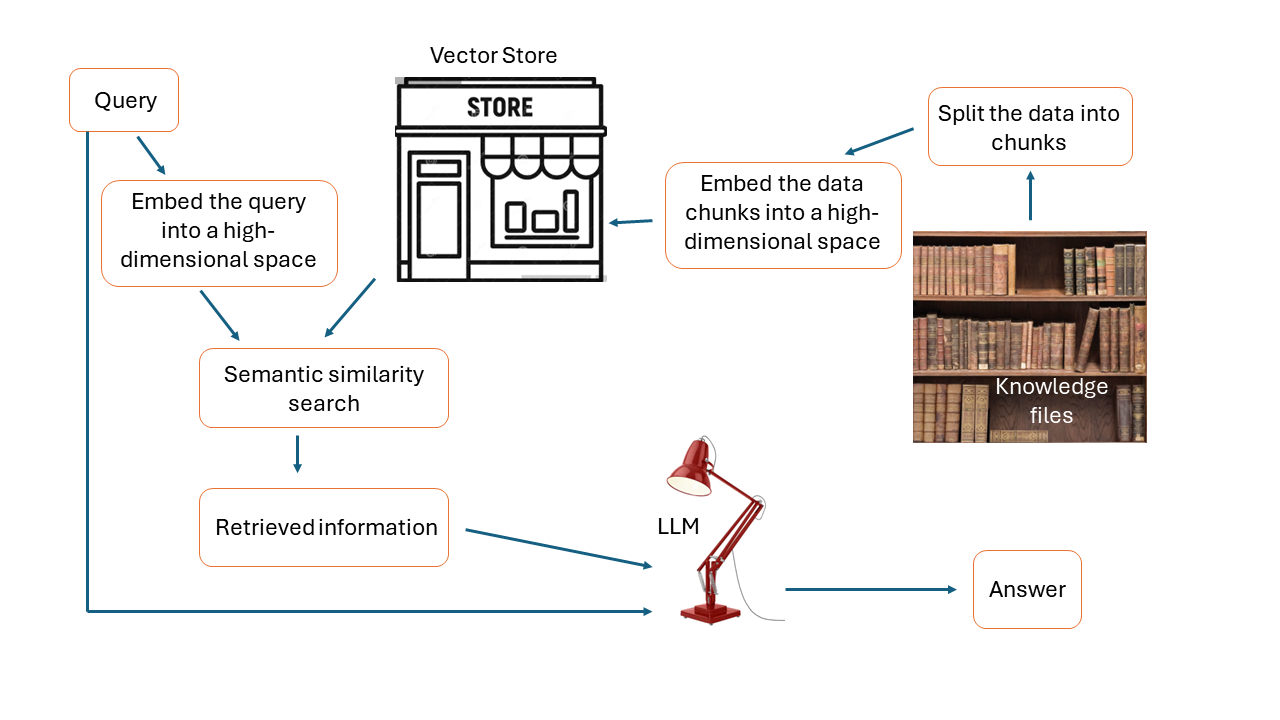

In [107]:
from PIL import Image

image_path = 'images/RAG_schematics.png'  
img = Image.open(image_path)
img.show()

# Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with. 

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format. 

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [108]:
import fitz  # PyMuPDF

def pdf_to_text(pdf_path, txt_path):
    # Open the PDF file
    with fitz.open(pdf_path) as doc:
        text = ""
        # Iterate through each page of the PDF
        for page in doc:
            # Extract text from the page
            text += page.get_text()
        
        # Save the extracted text to a text file
        with open(txt_path, "w", encoding="utf-8") as txt_file:
            txt_file.write(text)


pdf_path = "data/andrade_dissertation_copy.pdf"
txt_path = "data/andrade_dissertation_copy.txt"
pdf_to_text(pdf_path, txt_path)


In [109]:
text_loader = TextFileLoader("data/andrade_dissertation_copy.txt")
documents = text_loader.load_documents()
len(documents)

1

In [110]:
print(documents[0][:100])

On the mechanisms governing plasma
membrane organization - a STED-FCS
investigation
Dissertation
for


### Splitting Text Into Chunks

As we can see, there is one document - and it's the entire text of Frakenstein

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM. 

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length. 

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following: 
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

Let's take a peek visually at what we're doing here - and why it might be useful:

<img src="https://i.imgur.com/rtM6Ci6.png" />

As you can see (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [111]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

171

Let's take a look at some of the documents we've managed to split.

In [112]:
split_documents[0:1]

['On the mechanisms governing plasma\nmembrane organization - a STED-FCS\ninvestigation\nDissertation\nfor the award of the degree\n“Doctor rerum naturalium”\nDivision of Mathematics and Natural Sciences\nof the Georg-August-Universit¨at G¨ottingen\nsubmitted by\nD´ebora Machado Andrade\nfrom Aracaju, Brazil\nG¨ottingen 2013\nProf. Dr. Stefan W. Hell (Reviewer)\nDepartment of Nanobiophotonics\nMax Planck Institute for Biophysical Chemistry\nProf. Dr. J¨org Enderlein (Reviewer)\nGeorg-August-Universit¨at G¨ottingen\nProf. Dr. Erwin Neher\nMembrane Biophysics Department\nMax Planck Institute for Biophysical Chemistry\nDate of the oral examination: 06.01.2014\nii\nDeclaration\nI hereby ensure that the presented thesis “On the mechanisms governing\nplasma membrane organization - a STED-FCS investigation” has been writ-\nten independently and with no other sources and aids than quoted.\nG¨ottingen, November 27th 2013\niv\nAbstract\nThe plasma membrane is the barrier which localizes and sepa

### Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format. 

Loosely, this means turning the text into numbers. 

There are plenty of resources that talk about this process in great detail - I'll leave this [blog](https://txt.cohere.com/sentence-word-embeddings/) from Cohere.AI as a resource if you want to deep dive a bit. 

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

While this is all baked into 1 call - let's look at some of the code that powers this process:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model. 

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓QUESTION:

Though 1536 is the default dimension of `text-embedding-3-small`, you can pass a dimension parameter and shorten the vector - what method does OpenAI use to achieve this shortening?

**Answer** Although it is clear that OpenAI uses a dimensionality reduction method to achieve this, it is not clear which specific dimensionality reduction method they use from their documentation. It could potentially be Principal Component Analysis, it could be Singular Value Decomposition... dimensionality reduction is a very powerful technique, especially when it is possible to list dimensions or "modes" in order of relevance for a specific problem, and then truncate such output. 

In [113]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
# openai.api_key = os.getenv("OPENAI_API_KEY")

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [114]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓QUESTION:

What advantage does an async implementation provide for us?

**Answer**: async seems to be a much more robust implementation that allows for multiple I/O operations to be carried out in parallel, which is necessary for an effective scalable solution that can be taken to production. However, if an application is local and most importantly, CPU-bound, async will not bring many advantages so it might not be worth it given that it will increase the complexity of the code. For most other cases, an async paradigm would be the way to go as it makes a better use of the program's execution time and allows for scalability.

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus. 

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [115]:
vector_db.search_by_text("What are lipid rafts?", k=5)

[('orting, it has been enjoying vast acceptance by the scientiﬁc commu-\nnity since its formulation, becoming one of the most important paradigms of modern\ncell biology22. In fact, functions attributed to lipid rafts have spanned the manifold\nfunctions ascribed to the plasma membrane, with several connections between these\n5\n1. INTRODUCTION\nlipid platforms and diseases been postulated23,24. Nevertheless, the very existence of\nlipid rafts is still debatable23,25. The foundations for the lipid rafts hypothesis relied\non experiments with detergent extraction of biological membranes, whose conclusions\nwere drawn into question by several studies25. Although recent advances in biophysical\ntechniques have later allowed a more compelling body of evidence21,22, more conclusive\nproofs, such as the direct visualization of lipid rafts, as well as the determination of\ntheir characteristic lifetime, are still missing.\nFigure 1.2:\nCombination of the two currently most prominent membrane-

# Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work. 

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)): 

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this: 

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts. 

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-3.5-turbo"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓QUESTION:

How could we ensure our LLM always responded the same way to our inputs?

**Answer**: By decreasing the temperature to 0 the output of an LLM becomes more predictable, but it will still have a significant variability. As with any non-deterministic processes, the best way to make a program output consistent results is by **setting a fixed seed**. This can be done in the latest version of OpenAI SDK (1.3.3) by including the 'seed' parameter in the request to the API. 

### Creating and Prompting OpenAI's `gpt-3.5-turbo`!

Let's tie all these together and use it to prompt `gpt-3.5-turbo`!

In [116]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    user_role_prompt.create_message(
        content="In the context of plasma membrane diffusion, what is lipid hopping?"
    ),
    system_role_prompt.create_message(expertise="Biophysics"),
]

response = chat_openai.run(messages)

In [117]:
print(response)

Lipid hopping is a phenomenon that occurs in the plasma membrane during diffusion. It refers to the movement of lipids within the lipid bilayer by jumping from one location to another in a rapid and random manner. This movement is facilitated by the fluid nature of the membrane, allowing lipids to slide and diffuse within the bilayer. Lipid hopping plays a crucial role in maintaining the dynamic organization and fluidity of the plasma membrane, which is essential for various cellular processes such as signaling and transport.


### Retrieval Augmented Question Answering Prompt

Now we can create a RAQA prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [118]:
RAQA_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query. 

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

raqa_prompt = SystemRolePrompt(RAQA_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""

user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=5)
        
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = raqa_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)
        
        return self.llm.run([formatted_system_prompt, formatted_user_prompt])

#### ❓QUESTION:

What changes could you make that would encourage the LLM to have a more well thought out and verbose response? 
**Answer**: I could introduce the prompt "Think through your response step by step." at the assistant template. 

What is this method called?
**Answer**: This is the simplest form (but still very effective) of Chain of Thought (CoT) prompting.

In [119]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [120]:
retrieval_augmented_qa_pipeline.run_pipeline("What is lipid hopping?")

'Lipid hopping refers to the phenomenon where lipid molecules move between compartments with a certain probability when they hit the boundaries of a compartment. In the context provided, lipid hopping is mentioned in the discussion of lipid compartmentalized diffusion, also known as hop diffusion, which is being investigated using STED-FCS (stimulated emission depletion-fluorescence correlation spectroscopy) to study the diffusion of phospholipids labeled with a small organic dye in living cells.'

### Visibility Tooling

This is great, but what if we wanted to add some visibility to our pipeline?

Let's use Weights and Biases as a visibility tool!

The first thing we'll need to do is create a Weights and Biases account and get an API key. 

You can follow the process outlined [here](https://docs.wandb.ai/quickstart) to do exactly that!

Now we can get the Weights and Biases dependency and add our key to our env. to begin!

In [121]:
!pip install -q -U wandb

In [122]:
#wandb_key = getpass("Weights and Biases API Key: ")
#os.environ["WANDB_API_KEY"] = wandb_key
#wandb_key = os.getenv("WAND_API_KEY")
os.environ["WANDB_API_KEY"] = os.getenv("WAND_API_KEY")

In [123]:
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "RAQA Assignment.ipynb"
wandb.init(project="Visibility Example")

Now we can integrate Weights and Biases into our `RetrievalAugmentedQAPipeline`.

```python
if self.wandb_project:
            root_span = Trace(
                name="root_span",
                kind="llm",
                status_code=status,
                status_message=status_message,
                start_time_ms=start_time,
                end_time_ms=end_time,
                metadata={
                    "token_usage" : token_usage
                },
                inputs= {"system_prompt" : formatted_system_prompt, "user_prompt" : formatted_user_prompt},
                outputs= {"response" : response_text}
            )

            root_span.log(name="openai_trace")
```

The main things to consider here are how to populate the various fields to make sure we're tracking useful information. 

We'll use the `text_only` flag to ensure we can get detailed information about our LLM call!

You can check out all the parameters for Weights and Biases `Trace` [here](https://github.com/wandb/wandb/blob/653015a014281f45770aaf43627f64d9c4f04a32/wandb/sdk/data_types/trace_tree.py#L166)

In [124]:
import datetime
from wandb.sdk.data_types.trace_tree import Trace

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase, wandb_project = None) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever
        self.wandb_project = wandb_project

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)
        
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = raqa_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        
        start_time = datetime.datetime.now().timestamp() * 1000

        try:
            openai_response = self.llm.run([formatted_system_prompt, formatted_user_prompt], text_only=False)
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "success"
            status_message = (None, )
            response_text = openai_response.choices[0].message.content
            token_usage = dict(openai_response.usage)
            model = openai_response.model

        except Exception as e:
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "error"
            status_message = str(e)
            response_text = ""
            token_usage = {}
            model = ""

        if self.wandb_project:
            root_span = Trace(
                name="root_span",
                kind="llm",
                status_code=status,
                status_message=status_message,
                start_time_ms=start_time,
                end_time_ms=end_time,
                metadata={
                    "token_usage" : token_usage,
                    "model_name" : model
                },
                inputs= {"system_prompt" : formatted_system_prompt, "user_prompt" : formatted_user_prompt},
                outputs= {"response" : response_text}
            )

            root_span.log(name="openai_trace")
        
        return response_text if response_text else "We ran into an error. Please try again later. Full Error Message: " + status_message

In [125]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai,
    wandb_project="LLM Visibility Example"
)

In [126]:
retrieval_augmented_qa_pipeline.run_pipeline("Who is Batman?")

"I don't know."

In [127]:
retrieval_augmented_qa_pipeline.run_pipeline("We had previously done experiments with phosphoethanolamine (DPPE) in PtK2 cells that didn't show any lipid hopping. How can we explain that?")

'Based on the information provided, one way to explain the lack of lipid hopping observed in the previous experiments with phosphoethanolamine (DPPE) in PtK2 cells could be that the lipid diﬀusion in those particular cells was not characterized by hopping behavior. The current simulation model for phospholipid diﬀusion in PtK2 cells suggests that the lipid diﬀusion on PtK2 cells can be accurately described with certain parameters like compartment size (L = 25 nm), hopping probability (Phop = 0.25), and free diﬀusion coefficient (Dfree = 0.7 µm2/s). It is possible that in the previous experiments conducted on PtK2 cells with DPPE, the conditions did not promote or capture the lipid hopping behavior, leading to the absence of this phenomenon in the observations.\n\nTherefore, based on the current understanding and simulation model, the absence of lipid hopping in the previous experiments with DPPE in PtK2 cells could be attributed to the specific experimental conditions or factors that w

In [128]:
wandb.finish()

Navigate to the Weights and Biases "run" link to see how your LLM is performing!

```
View run at https://wandb.ai/deboramachadoandrade/Visibility%20Example/runs/nz5nxbvw

```

#### ❓QUESTION:

What is the `model_name` from the WandB `root_span` trace?

**Answer**: gpt-3.5-turbo-0125, which is a new iteration of GPT-3.5-turbo released in the beginning of 2024.

# Conclusion

In this notebook, we've gone through the steps required to create your own simple RAQA application!

Please feel free to extend this as much as you'd like. 